<a href="https://colab.research.google.com/github/mihirkulkarni50/Deep-Learning-Project/blob/main/Facial_Emotion_Detection_ipynb_Mihir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex- Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

# **Problem Statement**

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data. The solution to this problem is by recognizing facial emotions.

**Face Emotion Recognition**: This is a few shot learning live face emotion detection system. The model should be able to real-time identify the emotions of students in a live class.

# **Importing Dependencies**

In [1]:
# Importing libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19, ResNet152
from keras.models import Sequential, load_model
from keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os 

# DND Mode
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)

In [2]:
# Importing the drive to save trained models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Downloading the dataset
!gdown --id 1kdAI0wrR_bTBs-6pbKB6giz-JcNaTY-s

# Unzipping the files
!unzip '/content/dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [4]:
# Defining te path of train and test dataset
train_dir = '/content/train'
test_dir = '/content/test'

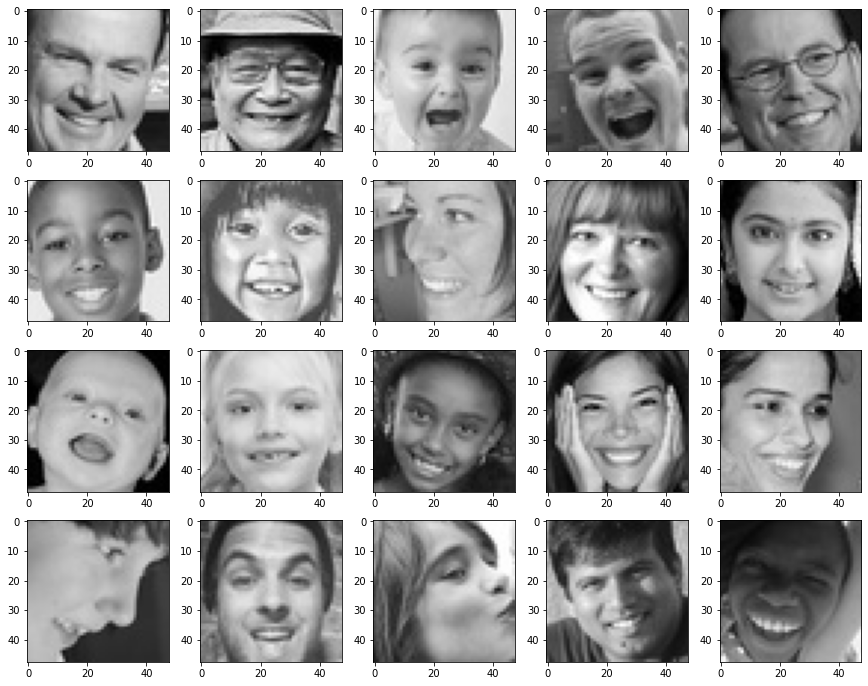

In [5]:
# Displaying sample Images
path = '/content/train/happy/'
plt.figure(figsize=(15,12))
for i in range(1, 21):
    plt.subplot(4,5,i)
    img = load_img(path + os.listdir(path)[i])
    plt.imshow(img)   
plt.show()

In [6]:
# Number of train images for each expression
base_path = "/content/"
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

4830 sad images
436 disgust images
4965 neutral images
7215 happy images
3171 surprise images
4097 fear images
3995 angry images


In [ ]:
# Generating batches of tensor image data
batch = 64 # setting the batch size for mini batch
img = (48,48) # setting the dimensions for image
color = "grayscale" # setting the color mode for images

# Setting the Data Generator for training data set 
train_gen = ImageDataGenerator()
# Setting the Data Generator for validation data set 
valid_gen = ImageDataGenerator()

# Fetching the files from train directory and performing the data augumentation
train_data = train_gen.flow_from_directory(train_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical", shuffle=True)
# Fetching the files from test directory and performing the data augumentation
validation = valid_gen.flow_from_directory(test_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical", shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


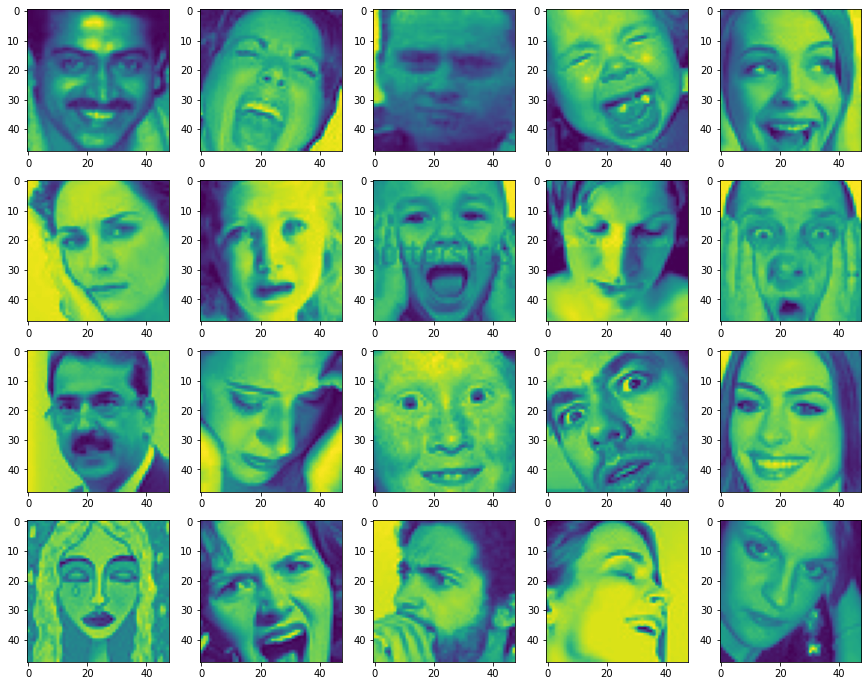

In [ ]:
# Displaying sample images from the training set after augmentation
random_image = np.random.choice(64, size=20, replace=False)
random_batch = np.random.choice(112,size=20, replace=False)
fig,axes=plt.subplots(4,5,figsize=(15,12))
for id, ax in enumerate(axes.flatten()):
  pic = train_data[random_batch[id]][0][random_image[id]]
  ax.imshow(pic.reshape(48,-1))

In [ ]:
# checking te shape of image and the label
image_batch, label_batch = next(iter(train_data))
print('image shape',image_batch[0].shape)
print('Label shape',label_batch[0].shape)

image shape (48, 48, 1)
Label shape (7,)


# **Defining prerequisites**

In [ ]:
# Defining a function to generate callbacks
def callback_list(name, esp=9, lrp=3):
    ''' Defining a function to generate the list of callbacks
    Arguments:
        name -- name of the model
        esp -- early stopping patience
        lrp -- reduce learning rate patience
    Returns:
        the list of callbacks
    '''
    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/{name}.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    # Stop training when a monitored metric has stopped improving.
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=esp, verbose=1, restore_best_weights=True)
    # Reduce learning rate when a metric has stopped improving.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=lrp, verbose=1, min_delta=0.0001)
    # Defining a list of all the callbacks
    callbacks = [earlystop, checkpoint, reduce_lr]

    return callbacks

In [ ]:
# Plot the training and validation accuracy and loss
def plots(history):
    ''' Defining a function to Plot the accuracy and loss
    Arguments:
        model.history
    Returns:
        plots of accuracy and loss for train and validation data
    '''
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
# Defining a function to plot the confusion matrix
def plotc(model, model_name='Model', test_data_gen = validation):
    ''' Defining a function to display the confusion matrix
    Arguments:
        model -- model.h5
        model_name -- name of the model
        test_data_gen -- test data generator object
    Returns:
        Plots the Confusion Matrix
    '''
    # compute predictions
    predictions = model.predict_generator(generator=test_data_gen)
    y_pred = [np.argmax(probas) for probas in predictions]
    y_test = test_data_gen.classes
    classes = test_data_gen.class_indices.keys()

    # compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plotting confusion matrix
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(f'{model_name} Confusion Matrix'.title())
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks+0.5, classes, rotation=45)
    plt.yticks(tick_marks+0.5, classes, rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# **Modified LeNet**

In [ ]:
# Defining modeified Lenet architecture using keras sequential API
lenet = Sequential([# First CNN layer
                    Conv2D(filters=6, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)),
                    BatchNormalization(), MaxPool2D(pool_size = 2),
                    # Second CNN layer
                    Conv2D(filters=16, kernel_size=3, activation='relu',  padding='same'),
                    BatchNormalization(), MaxPool2D(pool_size = 2),
                    # flattening and Adding 2 fully connected layers
                    Flatten(),
                    Dense(120, activation='relu'),
                    Dense(84, activation='relu'),
                    # using a prediction layer with seven neuron 
                    Dense(7, activation='softmax')])

# Compiling the model
lenet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 6)         60        
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        880       
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 16)       64        
 hNormalization)                                                 
                                                        

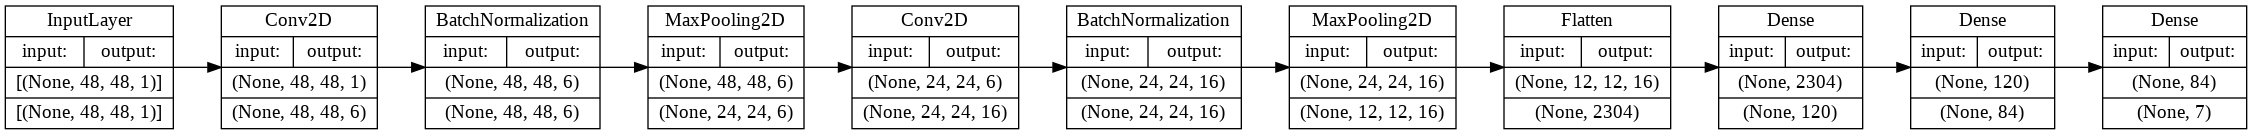

In [ ]:
# Plot model graph
plot_model(lenet, show_shapes=True, to_file='lenet.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
lenet_history = lenet.fit_generator(generator=train_data,
                                    steps_per_epoch=train_data.n//train_data.batch_size,
                                    epochs=50,
                                    validation_data = validation,
                                    validation_steps = validation.n//validation.batch_size,
                                    callbacks=callback_list('lenet')
                                    )

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.7735 - accuracy: 0.2974
Epoch 1: val_loss improved from inf to 1.66508, saving model to /content/drive/MyDrive/lenet.h5
448/448 [==============================] - 77s 171ms/step - loss: 1.7735 - accuracy: 0.2974 - val_loss: 1.6651 - val_accuracy: 0.3457 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.5481 - accuracy: 0.3994
Epoch 2: val_loss improved from 1.66508 to 1.56245, saving model to /content/drive/MyDrive/lenet.h5
448/448 [==============================] - 65s 144ms/step - loss: 1.5481 - accuracy: 0.3994 - val_loss: 1.5624 - val_accuracy: 0.3922 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.4327 - accuracy: 0.4552
Epoch 3: val_loss improved from 1.56245 to 1.51394, saving model to /content/drive/MyDrive/lenet.h5
448/448 [==============================] - 65s 145ms/step - loss: 1.4327 - accuracy: 0.4552 - val_loss: 1.5139 - v

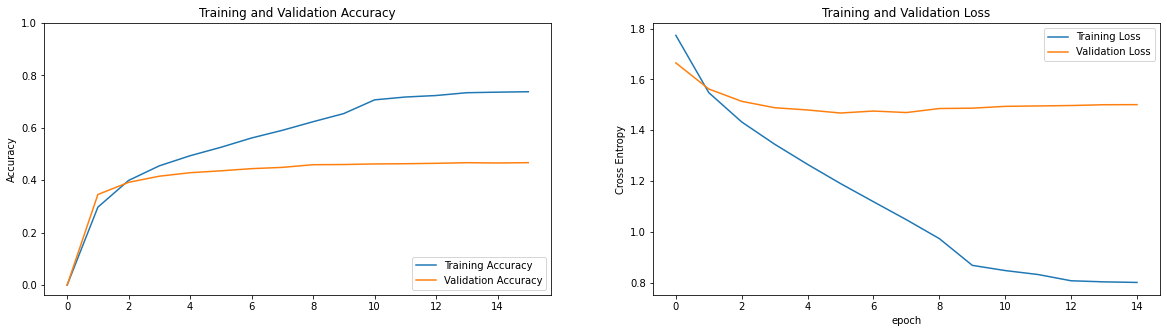

In [ ]:
# Plotting the accuracy and loss
plots(lenet_history)

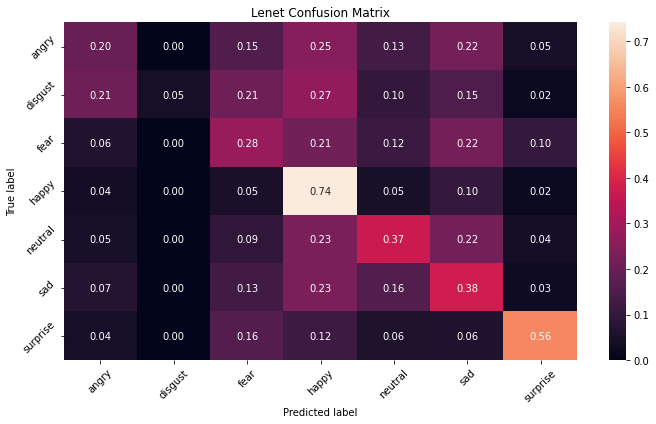

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=lenet, model_name='lenet')

In [ ]:
# Saving the model
lenet.save('/content/drive/MyDrive/lenet.h5')

# **Alexnet**

In [ ]:
# AlexNet CNN architecture from scratch using keras sequential API
alexnet = Sequential([# The first block with 1 conv
                      Conv2D(96, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)),
                      BatchNormalization(), MaxPool2D(pool_size=(2,2)),
                      # The second block with 1 conv
                      Conv2D(256, kernel_size=3, activation='relu', padding='same'),
                      BatchNormalization(), MaxPool2D(pool_size=(2,2)),
                      # The third block with 3 conv
                      Conv2D(384, kernel_size=3, activation='relu', padding='same'),
                      Conv2D(384, kernel_size=3, activation='relu', padding='same'),
                      Conv2D(256, kernel_size=3, activation='relu', padding='same'),
                      MaxPool2D(pool_size=(2,2)),
                      # Flattening and Using 2 fully connected layer with 4096 units and relu activation
                      Flatten(),
                      Dense(4096, activation='relu'), Dropout(0.5),
                      Dense(4096, activation='relu'), Dropout(0.5),
                      # Using a prediction layer with seven neuron
                      Dense(7, activation='softmax')])

# Compiling the model
alexnet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 96)        960       
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 256)       221440    
                                                                 
 batch_normalization_3 (Batc  (None, 24, 24, 256)      1024      
 hNormalization)                                                 
                                                      

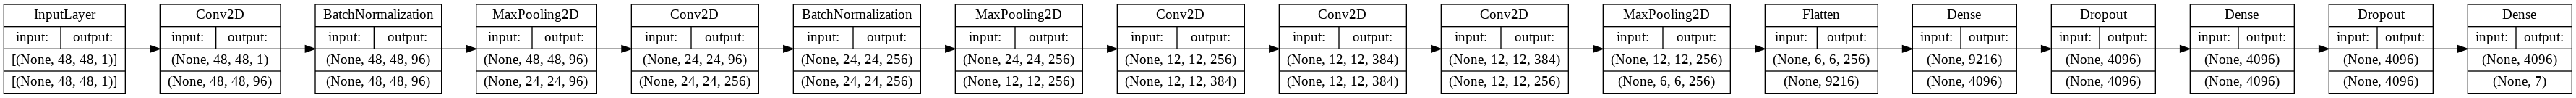

In [ ]:
# Plot model graph
plot_model(alexnet, to_file='alexnet.png', show_shapes=True, rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
alexnet_history = alexnet.fit_generator(generator=train_data,
                                        steps_per_epoch=train_data.n//train_data.batch_size,
                                        epochs=50,
                                        validation_data = validation,
                                        validation_steps = validation.n//validation.batch_size,
                                        callbacks=callback_list('alexnet')
                                        )

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.5962 - accuracy: 0.3729
Epoch 1: val_loss improved from inf to 1.38944, saving model to /content/drive/MyDrive/alexnet.h5
448/448 [==============================] - 2818s 6s/step - loss: 1.5962 - accuracy: 0.3729 - val_loss: 1.3894 - val_accuracy: 0.4576 - lr: 1.0000e-04
Epoch 2/50
128/448 [=======>......................] - ETA: 32:26 - loss: 1.3102 - accuracy: 0.4952

In [ ]:
# Plotting the accuracy and loss
plots(alexnet_history)

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=alexnet, model_name='alexnet')

In [ ]:
# Saving the model
alexnet.save('/content/drive/MyDrive/alexnet.h5')

# **Mobilenet**

In [ ]:
# categorical classification using MobileNetV2 
mobilenet = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for mobilenet
                        Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                        # Using MobileNetV2
                        MobileNetV2(weights='imagenet', include_top=False, pooling = 'avg'),
                        # Using a fully connected layer with 128 units and relu activation
                        Dense(128, activation='relu'),
                        # Using a fully connected layer with 64 units and relu activation
                        Dense(64, activation='relu'),
                        # Using a prediction layer with seven neuron
                        Dense(7, activation='softmax')])

# Compiling the model
mobilenet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
mobilenet.summary()

In [ ]:
# Plot model graph
plot_model(mobilenet, show_shapes=True, to_file='mobilenet.png', rankdir='LR')

In [ ]:
# Fitting the model
mobilenet_history = mobilenet.fit_generator(generator=train_data,
                                            steps_per_epoch=train_data.n//train_data.batch_size,
                                            epochs=50,
                                            validation_data = validation,
                                            validation_steps = validation.n//validation.batch_size,
                                            callbacks=callback_list('mobilenet')

In [ ]:
# Plotting the accuracy and loss
plots(mobilenet_history)

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=mobilenet, model_name='mobilenet')

In [ ]:
# Saving the model
mobilenet.save('/content/drive/MyDrive/mobilenet.h5')

# **VGG16**